[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juanesgutiz19/ia-project-bankruptcy-prediction/blob/master/05%20-%20Models%20with%20SMOTE.ipynb)

# Instalaciones necesarias

In [1]:
!pip install xgboost
!pip install catboost
!pip install pyarrow
!pip install fastparquet

In [2]:
!pip install pyarrow

In [3]:
!pip install fastparquet

# Importación de librerías

In [2]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action="ignore")
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import sklearn
import xgboost
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from imblearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

# Lectura del dataset limpio

In [3]:
df = pd.read_parquet('https://mlearner.s3.amazonaws.com/data/clean_data.parquet')
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,Operating Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,...,Working Capital/Equity_Low,Working Capital/Equity_Medium,Cash Flow to Sales_High,Cash Flow to Sales_Low,Cash Flow to Liability_High,Cash Flow to Liability_Low,Cash Flow to Liability_Medium,CFO to Assets_High,CFO to Assets_Low,CFO to Assets_Medium
0,1,0.370594,0.424389,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,...,0,0,1,0,0,0,1,0,0,1
1,1,0.464291,0.538214,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,...,0,0,1,0,0,0,1,1,0,0
2,1,0.426071,0.499019,0.601450,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,...,0,0,1,0,0,0,1,0,0,1
3,1,0.399844,0.451265,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,1.078888e-04,...,0,0,1,0,0,1,0,1,0,0
4,1,0.465022,0.538432,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,7.890000e+09,...,0,0,1,0,0,0,1,1,0,0


In [6]:
df.columns = df.columns.str.lstrip()

In [7]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower() for name in df.columns]
df.head()

,bankrupt?,r_o_a(_c) before interest and depreciation before interest,r_o_a(_a) before interest and % after tax,operating _gross _margin,operating _profit _rate,pre-tax net _interest _rate,after-tax net _interest _rate,non-industry income and expenditure/revenue,continuous interest rate (after tax),operating _expense _rate,...,working _capital/_equity__low,working _capital/_equity__medium,cash _flow to _sales__high,cash _flow to _sales__low,cash _flow to _liability__high,cash _flow to _liability__low,cash _flow to _liability__medium,c_f_o to _assets__high,c_f_o to _assets__low,c_f_o to _assets__medium
0,1,0.370594,0.424389,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,...,0,0,1,0,0,0,1,0,0,1
1,1,0.464291,0.538214,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,...,0,0,1,0,0,0,1,1,0,0
2,1,0.426071,0.499019,0.601450,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,...,0,0,1,0,0,0,1,0,0,1
3,1,0.399844,0.451265,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,1.078888e-04,...,0,0,1,0,0,1,0,1,0,0
4,1,0.465022,0.538432,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,7.890000e+09,...,0,0,1,0,0,0,1,1,0,0


# Características del dataset tras la limpieza

In [8]:
df.shape

(6819, 115)

In [9]:
df.columns

Index(['bankrupt?',
       'r_o_a(_c) before interest and depreciation before interest',
       'r_o_a(_a) before interest and % after tax', 'operating _gross _margin',
       'operating _profit _rate', 'pre-tax net _interest _rate',
       'after-tax net _interest _rate',
       'non-industry income and expenditure/revenue',
       'continuous interest rate (after tax)', 'operating _expense _rate',
       ...
       'working _capital/_equity__low', 'working _capital/_equity__medium',
       'cash _flow to _sales__high', 'cash _flow to _sales__low',
       'cash _flow to _liability__high', 'cash _flow to _liability__low',
       'cash _flow to _liability__medium', 'c_f_o to _assets__high',
       'c_f_o to _assets__low', 'c_f_o to _assets__medium'],
      dtype='object', length=115)

0    6599
1     220
Name: bankrupt?, dtype: int64


<AxesSubplot:xlabel='bankrupt?', ylabel='count'>

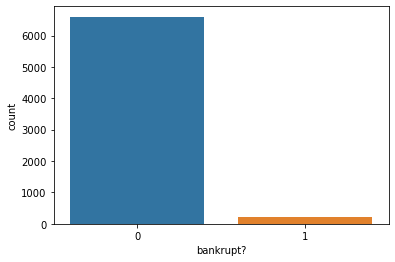

In [10]:
print(df['bankrupt?'].value_counts())
sns.countplot(x=df['bankrupt?'])

In [11]:
etiquetas = df['bankrupt?']
df = df.drop(['bankrupt?'], axis = 1)

In [12]:
etiquetas

0       1
1       1
2       1
3       1
4       1
       ..
6814    0
6815    0
6816    0
6817    0
6818    0
Name: bankrupt?, Length: 6819, dtype: int64

In [13]:
df

,r_o_a(_c) before interest and depreciation before interest,r_o_a(_a) before interest and % after tax,operating _gross _margin,operating _profit _rate,pre-tax net _interest _rate,after-tax net _interest _rate,non-industry income and expenditure/revenue,continuous interest rate (after tax),operating _expense _rate,research and development expense rate,...,working _capital/_equity__low,working _capital/_equity__medium,cash _flow to _sales__high,cash _flow to _sales__low,cash _flow to _liability__high,cash _flow to _liability__low,cash _flow to _liability__medium,c_f_o to _assets__high,c_f_o to _assets__low,c_f_o to _assets__medium
0,0.370594,0.424389,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.000000e+00,...,0,0,1,0,0,0,1,0,0,1
1,0.464291,0.538214,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.000000e+00,...,0,0,1,0,0,0,1,1,0,0
2,0.426071,0.499019,0.601450,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,2.550000e+07,...,0,0,1,0,0,0,1,0,0,1
3,0.399844,0.451265,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,1.078888e-04,0.000000e+00,...,0,0,1,0,0,1,0,1,0,0
4,0.465022,0.538432,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,7.890000e+09,0.000000e+00,...,0,0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0.493687,0.539468,0.604455,0.998992,0.797409,0.809331,0.303510,0.781588,1.510213e-04,4.500000e+09,...,0,0,1,0,0,0,1,1,0,0
6815,0.475162,0.538269,0.598308,0.998992,0.797414,0.809327,0.303520,0.781586,5.220000e+09,1.440000e+09,...,0,0,1,0,0,0,1,1,0,0
6816,0.472725,0.533744,0.610444,0.998984,0.797401,0.809317,0.303512,0.781546,2.509312e-04,1.039086e-04,...,0,0,1,0,0,0,1,1,0,0
6817,0.506264,0.559911,0.607850,0.999074,0.797500,0.809399,0.303498,0.781663,1.236154e-04,2.510000e+09,...,0,0,1,0,0,0,1,1,0,0


## División de datos de entrenamiento y test

In [14]:
X_train, X_test, y_train, y_test  = train_test_split(df, etiquetas, test_size=0.1, stratify = etiquetas, random_state = 42)

## Validación cruzada estratificada de K-Fold

In [15]:
skf = StratifiedKFold(n_splits=5, shuffle=False)

for index_train, index_test in skf.split(X_train, y_train):
    X_train_sm, X_val_sm = X_train.iloc[index_train], X_train.iloc[index_test]
    y_train_sm, y_val_sm = y_train.iloc[index_train], y_train.iloc[index_test]

X_train_sm = X_train_sm.values
X_val_sm = X_val_sm.values
y_train_sm = y_train_sm.values
y_val_sm = y_val_sm.values

## Regresión logística

In [16]:
accuracy_lst_reg = []
precision_lst_reg = []
recall_lst_reg = []
f1_lst_reg = []
auc_lst_reg = []

log_reg_sm = LogisticRegression()
log_reg_params = {"penalty": ['l2'],
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'class_weight': ['balanced',None],
                  'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


for train, val in skf.split(X_train_sm, y_train_sm):
    pipeline_reg = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model_reg = pipeline_reg.fit(X_train_sm[train], y_train_sm[train])
    best_est_reg = rand_log_reg.best_estimator_
    prediction_reg = best_est_reg.predict(X_train_sm[val])
    
    accuracy_lst_reg.append(pipeline_reg.score(X_train_sm[val], y_train_sm[val]))
    precision_lst_reg.append(precision_score(y_train_sm[val], prediction_reg))
    recall_lst_reg.append(recall_score(y_train_sm[val], prediction_reg))
    f1_lst_reg.append(f1_score(y_train_sm[val], prediction_reg))
    auc_lst_reg.append(roc_auc_score(y_train_sm[val], prediction_reg))


print('Logistic Regression (SMOTE) results:')
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_reg)))
print("precision: {}".format(np.mean(precision_lst_reg)))
print("recall: {}".format(np.mean(recall_lst_reg)))
print("f1: {}".format(np.mean(f1_lst_reg)))

Logistic Regression (SMOTE) results:

accuracy: 0.7313645621181262
precision: 0.052610575094235223
recall: 0.4300403225806452
f1: 0.09368949134416955


In [35]:
rand_log_reg.best_params_

{'solver': 'lbfgs', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 100}

In [20]:
label = ['Fin.Stable', 'Fin.Unstable']
pred_reg_sm = best_est_reg.predict(X_val_sm)
print(classification_report(y_val_sm, pred_reg_sm, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.98      0.76      0.86      1187
Fin.Unstable       0.06      0.45      0.11        40

    accuracy                           0.75      1227
   macro avg       0.52      0.61      0.48      1227
weighted avg       0.95      0.75      0.83      1227



## XGBoost

In [21]:

accuracy_lst_xgb = []
precision_lst_xgb = []
recall_lst_xgb = []
f1_lst_xgb = []
auc_lst_xgb = []

xgb_sm = xgboost.XGBClassifier(random_state = 42)
xgb_params = {'eta' : [0.1,0.01,0.001],  
              'eval_metric': ['logloss'],
              'max_depth' : [3,6,9],
              'lambda' : [1,1.5,2],      
              'alpha' : [0,0.5,1]}       
        
rand_xgb = RandomizedSearchCV(xgb_sm, xgb_params, n_iter=4)


for train, val in skf.split(X_train_sm, y_train_sm):
    pipeline_xgb = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_xgb) # SMOTE happens during Cross Validation not before..
    model_xgb = pipeline_xgb.fit(X_train_sm, y_train_sm)
    best_est_xgb = rand_xgb.best_estimator_
    prediction_xgb = best_est_xgb.predict(X_train_sm[val])
    
    accuracy_lst_xgb.append(pipeline_xgb.score(X_train_sm[val], y_train_sm[val]))
    precision_lst_xgb.append(precision_score(y_train_sm[val], prediction_xgb))
    recall_lst_xgb.append(recall_score(y_train_sm[val], prediction_xgb))
    f1_lst_xgb.append(f1_score(y_train_sm[val], prediction_xgb))
    auc_lst_xgb.append(roc_auc_score(y_train_sm[val], prediction_xgb))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_xgb)))
print("precision: {}".format(np.mean(precision_lst_xgb)))
print("recall: {}".format(np.mean(recall_lst_xgb)))
print("f1: {}".format(np.mean(f1_lst_xgb)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9824847250509166
precision: 0.7183071645335797
recall: 0.8983870967741936
f1: 0.7877473982617778
---------------------------------------------------------------------------------------------------------------------------------------


In [36]:
rand_xgb.best_params_

{'max_depth': 9,
 'lambda': 1.5,
 'eval_metric': 'logloss',
 'eta': 0.1,
 'alpha': 0.5}

In [23]:
smote_prediction_xgb = best_est_xgb.predict(X_val_sm)
print(classification_report(y_val_sm, smote_prediction_xgb, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.98      0.99      0.98      1187
Fin.Unstable       0.55      0.42      0.48        40

    accuracy                           0.97      1227
   macro avg       0.76      0.71      0.73      1227
weighted avg       0.97      0.97      0.97      1227



## Random Forest

In [24]:
accuracy_lst_rfc = []
precision_lst_rfc = []
recall_lst_rfc = []
f1_lst_rfc = []
auc_lst_rfc = []

rfc_sm = RandomForestClassifier()
rfc_params = {'max_features' : ['auto', 'sqrt', 'log2'],
              'random_state' : [42],
              'class_weight' : ['balanced','balanced_subsample'],
              'criterion' : ['gini', 'entropy'],
              'bootstrap' : [True, False]}
    
    
rand_rfc = RandomizedSearchCV(rfc_sm, rfc_params, n_iter=4)


for train, val in skf.split(X_train_sm, y_train_sm):
    pipeline_rfc = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_rfc)
    model_rfc = pipeline_rfc.fit(X_train_sm, y_train_sm)
    best_est_rfc = rand_rfc.best_estimator_
    prediction_rfc = best_est_rfc.predict(X_train_sm[val])
    
    accuracy_lst_rfc.append(pipeline_rfc.score(X_train_sm[val], y_train_sm[val]))
    precision_lst_rfc.append(precision_score(y_train_sm[val], prediction_rfc))
    recall_lst_rfc.append(recall_score(y_train_sm[val], prediction_rfc))
    f1_lst_rfc.append(f1_score(y_train_sm[val], prediction_rfc))
    auc_lst_rfc.append(roc_auc_score(y_train_sm[val], prediction_rfc))
    
print("accuracy: {}".format(np.mean(accuracy_lst_rfc)))
print("precision: {}".format(np.mean(precision_lst_rfc)))
print("recall: {}".format(np.mean(recall_lst_rfc)))
print("f1: {}".format(np.mean(f1_lst_rfc)))


accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0


In [37]:
rand_rfc.best_params_

{'random_state': 42,
 'max_features': 'sqrt',
 'criterion': 'entropy',
 'class_weight': 'balanced',
 'bootstrap': False}

In [25]:
label = ['Fin.Stable', 'Fin.Unstable']
smote_prediction_rfc = best_est_rfc.predict(X_val_sm)
print(classification_report(y_val_sm, smote_prediction_rfc, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.98      0.98      0.98      1187
Fin.Unstable       0.49      0.47      0.48        40

    accuracy                           0.97      1227
   macro avg       0.73      0.73      0.73      1227
weighted avg       0.97      0.97      0.97      1227



## Gradient Boosting

In [26]:
accuracy_lst_gbc = []
precision_lst_gbc = []
recall_lst_gbc = []
f1_lst_gbc = []
auc_lst_gbc = []

gbc_sm = GradientBoostingClassifier()
gbc_params = {'max_features' : ['auto', 'sqrt', 'log2'],
              'random_state' : [42],
              'n_estimators' : [20,50,100,200,300]}
    
    
rand_gbc = RandomizedSearchCV(gbc_sm, gbc_params, n_iter=4)


for train, val in skf.split(X_train_sm, y_train_sm):
    pipeline_gbc = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_gbc)
    model_gbc = pipeline_gbc.fit(X_train_sm, y_train_sm)
    best_est_gbc = rand_gbc.best_estimator_
    prediction_gbc = best_est_gbc.predict(X_train_sm[val])
    
    accuracy_lst_gbc.append(pipeline_gbc.score(X_train_sm[val], y_train_sm[val]))
    precision_lst_gbc.append(precision_score(y_train_sm[val], prediction_gbc))
    recall_lst_gbc.append(recall_score(y_train_sm[val], prediction_gbc))
    f1_lst_gbc.append(f1_score(y_train_sm[val], prediction_gbc))
    auc_lst_gbc.append(roc_auc_score(y_train_sm[val], prediction_gbc))
    
print("accuracy: {}".format(np.mean(accuracy_lst_gbc)))
print("precision: {}".format(np.mean(precision_lst_gbc)))
print("recall: {}".format(np.mean(recall_lst_gbc)))
print("f1: {}".format(np.mean(f1_lst_gbc)))

accuracy: 0.9881873727087577
precision: 0.7771310388957448
recall: 0.8987903225806452
f1: 0.8322406389084442


In [38]:
rand_gbc.best_params_

{'random_state': 42, 'n_estimators': 100, 'max_features': 'auto'}

In [27]:
smote_prediction_gbc = best_est_gbc.predict(X_val_sm)
print(classification_report(y_val_sm, smote_prediction_gbc, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.99      0.96      0.97      1187
Fin.Unstable       0.34      0.57      0.43        40

    accuracy                           0.95      1227
   macro avg       0.66      0.77      0.70      1227
weighted avg       0.96      0.95      0.96      1227



## Catboost

In [28]:
accuracy_lst_cbt = []
precision_lst_cbt = []
recall_lst_cbt = []
f1_lst_cbt = []
auc_lst_cbt = []

cbt_sm = CatBoostClassifier(verbose = 0)

cbt_params = {'eval_metric': ['F1'],
              'iterations': [100,500,1000],
              'learning_rate' : [0.1,0.01,0.001],
              'random_seed' : [42],
              'auto_class_weights' : ['Balanced','SqrtBalanced']
             }
    
    
rand_cbt = RandomizedSearchCV(cbt_sm, cbt_params, n_iter=4)

for train, val in skf.split(X_train_sm, y_train_sm):
    pipeline_cbt = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_cbt) # SMOTE happens during Cross Validation not before..
    model_cbt = pipeline_cbt.fit(X_train_sm, y_train_sm)
    best_est_cbt = rand_cbt.best_estimator_
    prediction_cbt = best_est_cbt.predict(X_train_sm[val])
    
    accuracy_lst_cbt.append(pipeline_cbt.score(X_train_sm[val], y_train_sm[val]))
    precision_lst_cbt.append(precision_score(y_train_sm[val], prediction_cbt))
    recall_lst_cbt.append(recall_score(y_train_sm[val], prediction_cbt))
    f1_lst_cbt.append(f1_score(y_train_sm[val], prediction_cbt))
    auc_lst_cbt.append(roc_auc_score(y_train_sm[val], prediction_cbt))
    

print("accuracy: {}".format(np.mean(accuracy_lst_cbt)))
print("precision: {}".format(np.mean(precision_lst_cbt)))
print("recall: {}".format(np.mean(recall_lst_cbt)))
print("f1: {}".format(np.mean(f1_lst_cbt)))

accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0


In [29]:
smote_prediction_cbt = best_est_cbt.predict(X_val_sm)
print(classification_report(y_val_sm, smote_prediction_cbt, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.98      0.99      0.98      1187
Fin.Unstable       0.56      0.45      0.50        40

    accuracy                           0.97      1227
   macro avg       0.77      0.72      0.74      1227
weighted avg       0.97      0.97      0.97      1227



In [39]:
rand_cbt.best_params_

{'random_seed': 42,
 'learning_rate': 0.1,
 'iterations': 500,
 'eval_metric': 'F1',
 'auto_class_weights': 'SqrtBalanced'}

## Curvas ROC

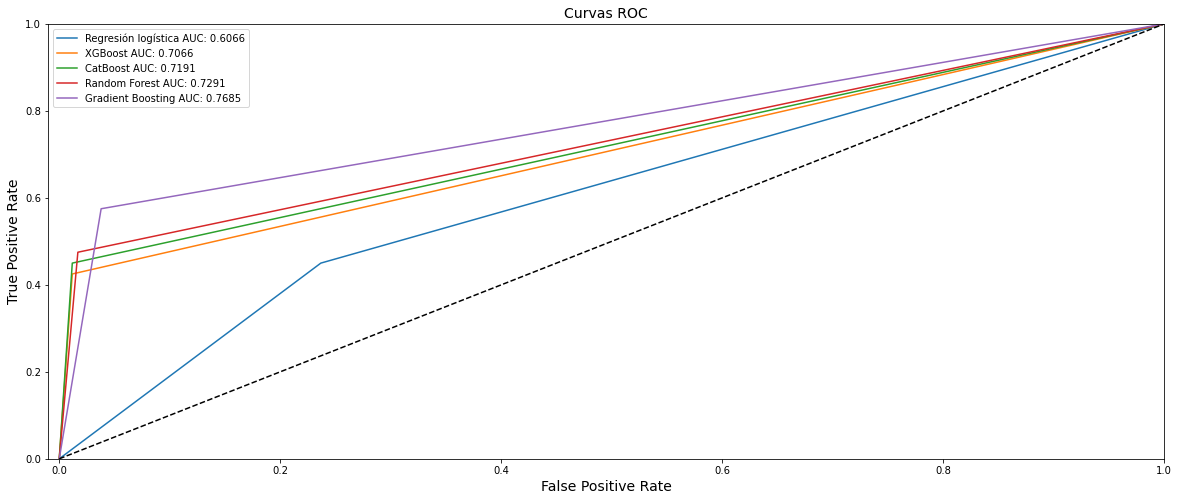

In [31]:
from sklearn.metrics import roc_curve

log_false_positive_rate, log_true_positive_rate, _ = roc_curve(y_val_sm, pred_reg_sm)
xgb_false_positive_rate, xgb_true_positive_rate, _ = roc_curve(y_val_sm, smote_prediction_xgb)
rfc_false_positive_rate, rfc_true_positive_rate, _ = roc_curve(y_val_sm, smote_prediction_rfc)
gbc_false_positive_rate, gbc_true_positive_rate, _ = roc_curve(y_val_sm, smote_prediction_gbc)
cat_false_positive_rate, cat_true_positive_rate, _ = roc_curve(y_val_sm, smote_prediction_cbt)


def graficar_curvas_ROC(log_false_positive_rate, log_true_positive_rate, rfc_false_positive_rate, rfc_true_positive_rate, xgb_false_positive_rate, xgb_true_positive_rate, cat_false_positive_rate, cat_true_positive_rate, gbc_false_positive_rate, gbc_true_positive_rate):
    plt.figure(figsize=(20,8))
    plt.title('Curvas ROC', fontsize=14)
    plt.plot(log_false_positive_rate, log_true_positive_rate, label='Regresión logística AUC: {:.4f}'.format(roc_auc_score(y_val_sm, pred_reg_sm)))
    plt.plot(xgb_false_positive_rate, xgb_true_positive_rate, label='XGBoost AUC: {:.4f}'.format(roc_auc_score(y_val_sm, smote_prediction_xgb)))
    plt.plot(cat_false_positive_rate, cat_true_positive_rate, label='CatBoost AUC: {:.4f}'.format(roc_auc_score(y_val_sm, smote_prediction_cbt)))
    plt.plot(rfc_false_positive_rate, rfc_true_positive_rate, label='Random Forest AUC: {:.4f}'.format(roc_auc_score(y_val_sm, smote_prediction_rfc)))
    plt.plot(gbc_false_positive_rate, gbc_true_positive_rate, label='Gradient Boosting AUC: {:.4f}'.format(roc_auc_score(y_val_sm, smote_prediction_gbc)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend()
    
graficar_curvas_ROC(log_false_positive_rate, log_true_positive_rate, rfc_false_positive_rate, rfc_true_positive_rate, xgb_false_positive_rate, xgb_true_positive_rate, cat_false_positive_rate, cat_true_positive_rate, gbc_false_positive_rate, gbc_true_positive_rate)

plt.show()

## Matrices de confusión

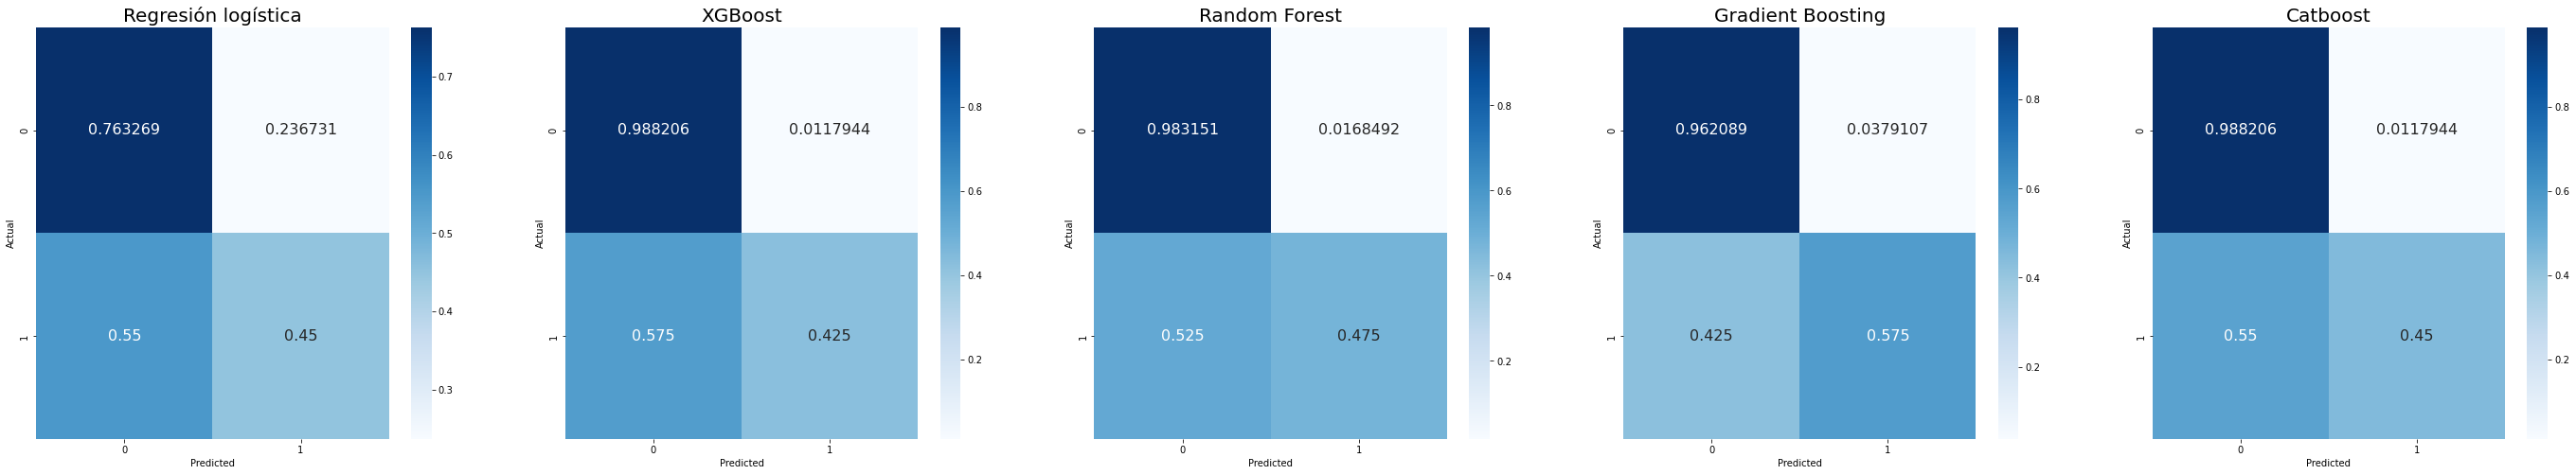

In [34]:
confusion_matrix_reg = confusion_matrix(y_val_sm, pred_reg_sm, normalize='true')
confusion_matrix_xgb = confusion_matrix(y_val_sm, smote_prediction_xgb, normalize='true')
confusion_matrix_rfc = confusion_matrix(y_val_sm, smote_prediction_rfc, normalize='true')
confusion_matrix_gbc = confusion_matrix(y_val_sm, smote_prediction_gbc, normalize='true')
confusion_matrix_cbt = confusion_matrix(y_val_sm, smote_prediction_cbt, normalize='true')

heat_cm0 = pd.DataFrame(confusion_matrix_reg, columns=np.unique(y_val_sm), index = np.unique(y_val_sm))
heat_cm0.index.name = 'Actual'
heat_cm0.columns.name = 'Predicted'

heat_cm1 = pd.DataFrame(confusion_matrix_xgb, columns=np.unique(y_val_sm), index = np.unique(y_val_sm))
heat_cm1.index.name = 'Actual'
heat_cm1.columns.name = 'Predicted'

heat_cm2 = pd.DataFrame(confusion_matrix_rfc, columns=np.unique(y_val_sm), index = np.unique(y_val_sm))
heat_cm2.index.name = 'Actual'
heat_cm2.columns.name = 'Predicted'

heat_cm3 = pd.DataFrame(confusion_matrix_gbc, columns=np.unique(y_val_sm), index = np.unique(y_val_sm))
heat_cm3.index.name = 'Actual'
heat_cm3.columns.name = 'Predicted'

heat_cm4 = pd.DataFrame(confusion_matrix_cbt, columns=np.unique(y_val_sm), index = np.unique(y_val_sm))
heat_cm4.index.name = 'Actual'
heat_cm4.columns.name = 'Predicted'

f, ax = plt.subplots(1, 5, figsize=(20,8))
f.subplots_adjust(left=None, bottom=None, right= 2, top=None, wspace=None, hspace= None)

sns.heatmap(heat_cm0, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[0])
ax[0].set_title('Regresión logística', fontsize = 20)
sns.heatmap(heat_cm1, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[1])
ax[1].set_title('XGBoost', fontsize = 20)
sns.heatmap(heat_cm2, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[2])
ax[2].set_title('Random Forest', fontsize = 20)
sns.heatmap(heat_cm3, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[3])
ax[3].set_title('Gradient Boosting', fontsize = 20)
sns.heatmap(heat_cm4, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[4])
ax[4].set_title('Catboost', fontsize = 20)

plt.show()

## Testing de mejores modelos con conjunto de test

In [40]:
test_pred_rfc = best_est_rfc.predict(X_test)
test_pred_gbc = best_est_gbc.predict(X_test)

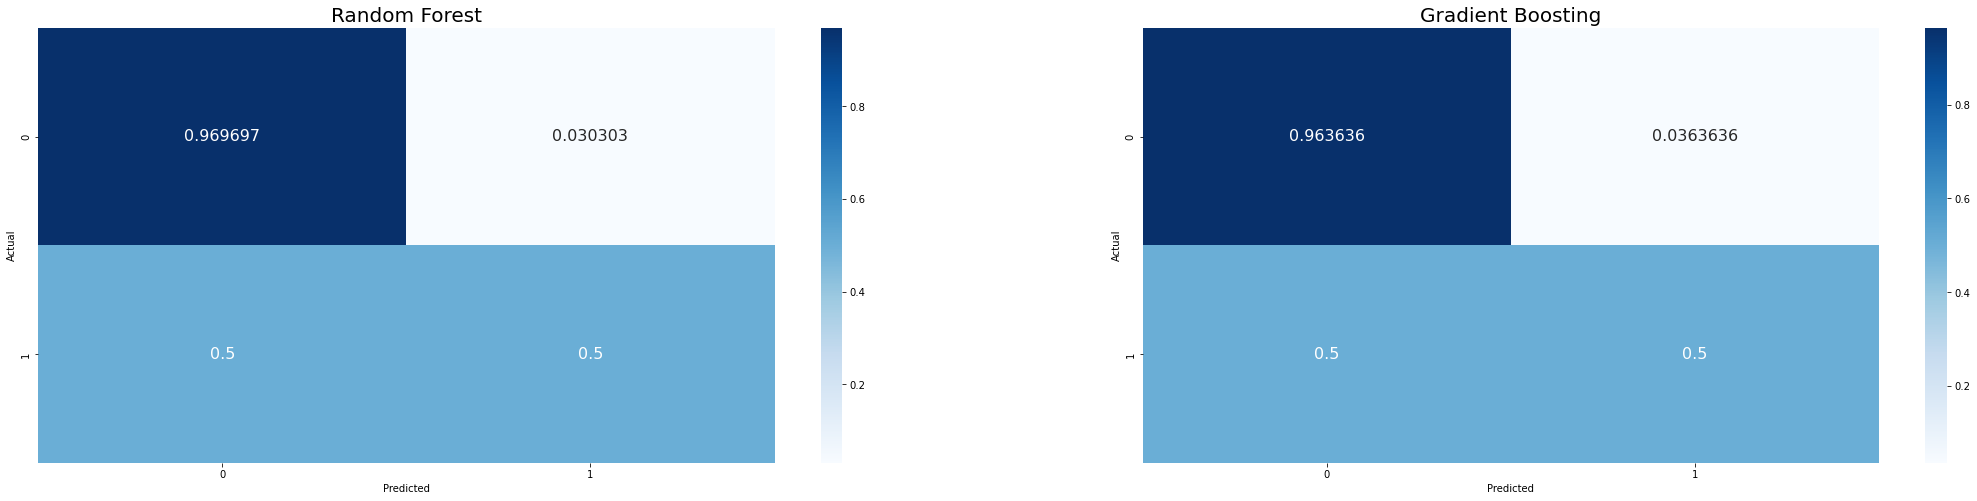

In [42]:
confusion_matrix_rfc = confusion_matrix(y_test, test_pred_rfc, normalize='true')
confusion_matrix_gbc = confusion_matrix(y_test, test_pred_gbc, normalize='true')

heat_cm0 = pd.DataFrame(confusion_matrix_rfc, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm0.index.name = 'Actual'
heat_cm0.columns.name = 'Predicted'

heat_cm1 = pd.DataFrame(confusion_matrix_gbc, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm1.index.name = 'Actual'
heat_cm1.columns.name = 'Predicted'

f, ax = plt.subplots(1, 2, figsize=(15,8))
f.subplots_adjust(left=None, bottom=None, right= 2, top=None, wspace=None, hspace= None)

sns.heatmap(heat_cm0, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[0])
ax[0].set_title('Random Forest', fontsize = 20)
sns.heatmap(heat_cm1, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[1])
ax[1].set_title('Gradient Boosting', fontsize = 20)

plt.show()

In [43]:
print(classification_report(y_test, test_pred_rfc, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.98      0.97      0.98       660
Fin.Unstable       0.35      0.50      0.42        22

    accuracy                           0.95       682
   macro avg       0.67      0.73      0.70       682
weighted avg       0.96      0.95      0.96       682



In [44]:
print(classification_report(y_test, test_pred_gbc, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.98      0.96      0.97       660
Fin.Unstable       0.31      0.50      0.39        22

    accuracy                           0.95       682
   macro avg       0.65      0.73      0.68       682
weighted avg       0.96      0.95      0.95       682

